In [277]:
from bs4 import BeautifulSoup,Comment
import urllib.request
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
from sklearn import linear_model
from sklearn.cluster import KMeans
#from pandas import DataFrame as df

sns.set()

In [278]:
#to get soup for 2020 team offense using Comment, used below
url = "https://www.pro-football-reference.com/years/2020/"
soup = BeautifulSoup(requests.get(url).content, 'html.parser')
table = soup.select_one('#all_team_stats').find_next(text=lambda t: isinstance(t, Comment))
table = BeautifulSoup(table, 'html.parser')



In [279]:
#what the HTML looks like
table.prettify()[0:2500]

'<div class="table_container" id="div_team_stats">\n <table class="per_match_toggle sortable stats_table" data-cols-to-freeze=",2" id="team_stats">\n  <caption>\n   Team Offense Table\n  </caption>\n  <colgroup>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n   <col/>\n  </colgroup>\n  <thead>\n   <tr class="over_header">\n    <th aria-label="" class="over_header center" colspan="2" data-stat="">\n    </th>\n    <th>\n    </th>\n    <th>\n    </th>\n    <th>\n    </th>\n    <th aria-label="" class="over_header center" colspan="3" data-stat="header_tot_off_tgl">\n     Tot Yds &amp; TO\n    </th>\n    <th>\n    </th>\n    <th>\n    </th>\n    <th aria-label="" class="over_header center" colspan="7" data-stat="header_pass">\n     Passing\n   

In [280]:
#function to rename columns to unique Offense/Defense data and columns that are missing titles from HTML table
def rename_cols(df):
    dict = {'Unnamed: 0_level_0':'TotOff',
            'Unnamed: 1_level_0':'TotOff',
            'Unnamed: 2_level_0':'TotOff',
            'Unnamed: 3_level_0':'TotOff',
            'Unnamed: 4_level_0':'TotOff',
            'Passing' : 'O_Passing',
            'Rushing' : 'O_Rushing',
            'Penalties': 'O_Penalties',
            'Tot Yds & TO':'TotOff',
            'Unnamed: 8_level_0':'TotOff',
            'Unnamed: 9_level_0':'TotOff',
            'Unnamed: 25_level_0':'O_Score%',
            'Unnamed: 26_level_0':'O_TurnOver%',
            'Unnamed: 27_level_0':'O_EXP',}
        
    # call rename() method
    df.rename(columns=dict,inplace=True)
    return(df)

def rename_cols_DEF(df):
    dict = {'Unnamed: 0_level_0':'TotDef',
            'Unnamed: 1_level_0':'TotDef',
            'Unnamed: 2_level_0':'TotDef',
            'Unnamed: 3_level_0':'TotDef',
            'Unnamed: 4_level_0':'TotDef',
            'Passing' : 'D_Passing',
            'Rushing' : 'D_Rushing',
            'Penalties': 'D_Penalties',
            'Tot Yds & TO':'TotDef',
            'Unnamed: 8_level_0':'TotDef',
            'Unnamed: 9_level_0':'TotDef',
            'Unnamed: 25_level_0':'D_Score%',
            'Unnamed: 26_level_0':'D_TurnOver%',
            'Unnamed: 27_level_0':'D_EXP',}
        
    # call rename() method
    df.rename(columns=dict,inplace=True)
    return(df)

In [281]:
#Get Team Offense Data
#for loop to get data for X years


year = 2020
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
OFFdfs = []
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/')
    years = year - index

count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    table = soup.select_one('#all_team_stats').find_next(text=lambda t: isinstance(t, Comment))
    table = BeautifulSoup(table, 'html.parser')    
    #create DF from html table, drop last 3 rows of data 
    OFFdf = pd.read_html(str(table))[0]
    curr_year = year - count
    OFFdf['Year'] = curr_year
    OFFdfs.append(OFFdf[:-3])
    count+=1


#initialize Master Team Offense Dataframe    
MasterOFF = OFFdfs[0]

for i in range(len(OFFdfs)-1):    
    #append DF to master, reset index to continuous
    MasterOFF = MasterOFF.append(OFFdfs[i+1],ignore_index = True)

#rename columns to useful index    
MasterOFF = rename_cols(MasterOFF)
#drop multi-index
MasterOFF.columns = ['_'.join(col) for col in MasterOFF.columns]
#cleanup Year column index
MasterOFF.rename(columns={'Year_':'Year'},inplace=True)

In [282]:
#Get Team Defense Data
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
year = 2020
DEFdfs = []
ADV_DEFdf = []
Team_Sacks = pd.DataFrame(['Tm','Sk'])
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/opp.htm')
    years = year - index

    
#mask for advanced_defense table data
sacks = ['Tm','Sk','Year']

#team_stats table does not include Sacks, so need passing table data and merge tables.
count = 0
for index in urls:
    curr_year = year - count
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    table = soup.find('table', id = 'team_stats') 
    table2 = soup.select_one('#all_passing').find_next(text=lambda t: isinstance(t, Comment))
    table2 = BeautifulSoup(table2, 'html.parser')
    #create DF from html table, drop last 3 rows of data 
    DEFdf = pd.read_html(str(table))[0]
    DEFdf.drop(DEFdf.tail(3).index, inplace = True)
    #rename each DF
    rename_cols_DEF(DEFdf)
    #add year data
    DEFdf['Year'] = curr_year
    #drop multi-index
    DEFdf.columns = ['_'.join(col) for col in DEFdf.columns]
    
    ADV_DEFdf = pd.read_html(str(table2))[0]
    ADV_DEFdf.drop(ADV_DEFdf.tail(3).index,inplace = True)
    ADV_DEFdf['Year'] = curr_year
    #apply mask
    Team_Sacks = ADV_DEFdf[sacks].copy()
    #intermediate step prior to appending data. merges team_stats and team sacks data 
    DEFdf_interm = pd.merge(DEFdf,Team_Sacks, left_on =['TotDef_Tm'], right_on = ['Tm'] )
    #append to list of team defense data
   
    DEFdfs.append(DEFdf_interm)
    count+=1


#initialize master DataFrame with first list of Team Defense data
MasterDEF = DEFdfs[0]

for i in range(len(DEFdfs)-1):    
    #append DF to master, reset index to continuous
    MasterDEF = MasterDEF.append(DEFdfs[i+1],ignore_index = True)
    
MasterDEF.drop('Tm',axis = 1,inplace=True)
MasterDEF.drop('Year_',axis = 1,inplace=True)
MasterDEF.head(5)

,TotDef_Rk,TotDef_Tm,TotDef_G,TotDef_PF,TotDef_Yds,TotDef_Ply,TotDef_Y/P,TotDef_TO,TotDef_FL,TotDef_1stD,...,D_Rushing_Y/A,D_Rushing_1stD,D_Penalties_Pen,D_Penalties_Yds,D_Penalties_1stPy,D_Score%_Sc%,D_TurnOver%_TO%,D_EXP_EXP,Sk,Year
0,1.0,Los Angeles Rams,16.0,296.0,4511.0,989.0,4.6,22.0,8.0,280.0,...,3.8,91.0,78.0,582.0,19.0,27.9,12.0,85.89,53.0,2020
1,2.0,Baltimore Ravens,16.0,303.0,5276.0,1017.0,5.2,22.0,12.0,347.0,...,4.6,96.0,77.0,646.0,38.0,30.0,12.4,-17.69,39.0,2020
2,3.0,Pittsburgh Steelers,16.0,312.0,4893.0,996.0,4.9,27.0,9.0,281.0,...,4.3,94.0,103.0,980.0,24.0,29.3,13.8,33.24,56.0,2020
3,4.0,Washington Football Team,16.0,329.0,4873.0,1004.0,4.9,23.0,7.0,289.0,...,4.2,100.0,85.0,708.0,28.0,31.4,12.2,32.51,47.0,2020
4,5.0,New Orleans Saints,16.0,337.0,4974.0,992.0,5.0,26.0,8.0,320.0,...,3.9,85.0,64.0,517.0,50.0,34.7,13.1,-40.02,45.0,2020


In [283]:
#get standings inlcuding win-loss record

#for loop to get data for X years
year = 2020
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
AFCStandDfs = []
NFCStandDfs = []
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/')
    years = year - index

count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    #AFCtable = soup.select('table', id='AFC')
    #NFCtable = soup.select('table', id='NFC')
    AFCtable = soup.findAll('table', {'id':['AFC']})
    NFCtable = soup.findAll('table', {'id':['NFC']})
    AFCStandDf = pd.read_html(str(AFCtable))[0]
    NFCStandDf = pd.read_html(str(NFCtable))[0]
    curr_year = year - count
    AFCStandDf['Year'] = curr_year
    AFCStandDfs.append(AFCStandDf)
    NFCStandDf['Year'] = curr_year
    NFCStandDfs.append(NFCStandDf)    
    count+=1


#initialize Dataframe    
AFCStandings = AFCStandDfs[0]
NFCStandings = NFCStandDfs[0]
for i in range(len(AFCStandDfs)-1):    
    #append DF, reset index to continuous
    AFCStandings = AFCStandings.append(AFCStandDfs[i+1],ignore_index = True)
for i in range(len(NFCStandDfs)-1):
    NFCStandings = NFCStandings.append(NFCStandDfs[i+1],ignore_index = True)

#drop conference labels (north,east,west,south)    
AFCStandings.drop(AFCStandings.index[0:len(AFCStandings):5], inplace = True)
NFCStandings.drop(NFCStandings.index[0:len(NFCStandings):5], inplace = True)

#strip character marker
AFCStandings['Tm'] = AFCStandings['Tm'].str.rstrip('*'+'+')
NFCStandings['Tm'] = NFCStandings['Tm'].str.rstrip('*'+'+')

#combine standings
Standings = NFCStandings.append(AFCStandings)

Standings.drop(['MoV','SoS','SRS','OSRS','DSRS','PF','PA'],axis = 1,inplace = True)

#change object type to float
Standings['W'] = Standings['W'].astype(float)
Standings['L'] = Standings['L'].astype(float)
Standings['T'] = Standings['T'].astype(float)
Standings['W-L%'] = Standings['W-L%'].astype(float)
Standings['PD'] = Standings['PD'].astype(float)
Standings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 1 to 199
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tm      320 non-null    object 
 1   W       320 non-null    float64
 2   L       320 non-null    float64
 3   T       224 non-null    float64
 4   W-L%    320 non-null    float64
 5   PD      320 non-null    float64
 6   Year    320 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 20.0+ KB


In [284]:
#get playoff results data
#includes winner and score

#for loop to get data for X years


year = 2020
#URL for website data
url = "https://www.pro-football-reference.com/years/"
urls = []
PlayOffdfs = []
for index in np.arange(10):
    #create URL for BeautifulSoup
    urls.append(url + str(year - index) +'/')
    years = year - index

count = 0
for index in urls:
    soup = BeautifulSoup(requests.get(index).content, 'html.parser')
    table = soup.select_one('#all_playoff_results').find_next(text=lambda t: isinstance(t, Comment))
    table = BeautifulSoup(table, 'html.parser') 
    PlayOffdf = pd.read_html(str(table))[0]
    curr_year = year - count
    PlayOffdf['Year'] = curr_year
    PlayOffdfs.append(PlayOffdf)
    count+=1


#initialize Playoffs Dataframe    
PlayOffs = PlayOffdfs[0]

for i in range(len(PlayOffdfs)-1):    
    #append DF, reset index to continuous
    PlayOffs = PlayOffs.append(PlayOffdfs[i+1],ignore_index = True)





In [285]:
PlayOffs.head(13)

,Week,Day,Date,Winner/tie,Unnamed: 4,Loser/tie,Unnamed: 6,Pts,Pts.1,Year
0,WildCard,Sat,2021-01-09,Buffalo Bills,NaN,Indianapolis Colts,boxscore,27,24,2020
1,WildCard,Sat,2021-01-09,Los Angeles Rams,@,Seattle Seahawks,boxscore,30,20,2020
2,WildCard,Sat,2021-01-09,Tampa Bay Buccaneers,@,Washington Football Team,boxscore,31,23,2020
3,WildCard,Sun,2021-01-10,Cleveland Browns,@,Pittsburgh Steelers,boxscore,48,37,2020
4,WildCard,Sun,2021-01-10,New Orleans Saints,NaN,Chicago Bears,boxscore,21,9,2020
5,WildCard,Sun,2021-01-10,Baltimore Ravens,@,Tennessee Titans,boxscore,20,13,2020
6,Division,Sat,2021-01-16,Green Bay Packers,NaN,Los Angeles Rams,boxscore,32,18,2020
7,Division,Sat,2021-01-16,Buffalo Bills,NaN,Baltimore Ravens,boxscore,17,3,2020
8,Division,Sun,2021-01-17,Kansas City Chiefs,NaN,Cleveland Browns,boxscore,22,17,2020
9,Division,Sun,2021-01-17,Tampa Bay Buccaneers,@,New Orleans Saints,boxscore,30,20,2020


In [286]:
PlayOffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Week        112 non-null    object
 1   Day         112 non-null    object
 2   Date        112 non-null    object
 3   Winner/tie  112 non-null    object
 4   Unnamed: 4  46 non-null     object
 5   Loser/tie   112 non-null    object
 6   Unnamed: 6  112 non-null    object
 7   Pts         112 non-null    int64 
 8   Pts.1       112 non-null    int64 
 9   Year        112 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 8.9+ KB


In [287]:
PlayOffs.keys()

Index(['Week', 'Day', 'Date', 'Winner/tie', 'Unnamed: 4', 'Loser/tie',
       'Unnamed: 6', 'Pts', 'Pts.1', 'Year'],
      dtype='object')

In [288]:
SBWinner = PlayOffs.loc[PlayOffs['Week']=='SuperBowl']

In [289]:
SBWinner

,Week,Day,Date,Winner/tie,Unnamed: 4,Loser/tie,Unnamed: 6,Pts,Pts.1,Year
12,SuperBowl,Sun,2021-02-07,Tampa Bay Buccaneers,N,Kansas City Chiefs,boxscore,31,9,2020
23,SuperBowl,Sun,2020-02-02,Kansas City Chiefs,N,San Francisco 49ers,boxscore,31,20,2019
34,SuperBowl,Sun,2019-02-03,New England Patriots,N,Los Angeles Rams,boxscore,13,3,2018
45,SuperBowl,Sun,2018-02-04,Philadelphia Eagles,N,New England Patriots,boxscore,41,33,2017
56,SuperBowl,Sun,2017-02-05,New England Patriots,N,Atlanta Falcons,boxscore,34,28,2016
67,SuperBowl,Sun,2016-02-07,Denver Broncos,N,Carolina Panthers,boxscore,24,10,2015
78,SuperBowl,Sun,2015-02-01,New England Patriots,N,Seattle Seahawks,boxscore,28,24,2014
89,SuperBowl,Sun,2014-02-02,Seattle Seahawks,N,Denver Broncos,boxscore,43,8,2013
100,SuperBowl,Sun,2013-02-03,Baltimore Ravens,N,San Francisco 49ers,boxscore,34,31,2012
111,SuperBowl,Sun,2012-02-05,New York Giants,N,New England Patriots,boxscore,21,17,2011


In [290]:
#assigning binary superbowl win column to master team offense dataframe.
#this block should be put into a for loop

MasterOFF[('SB_Win')] = 0

row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Tampa Bay Buccaneers') & (MasterOFF['Year'] == 2020)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Kansas City Chiefs') & (MasterOFF['Year'] == 2019)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'New England Patriots') & (MasterOFF['Year'] == 2018)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Philadelphia Eagles') & (MasterOFF['Year'] == 2017)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'New England Patriots') & (MasterOFF['Year'] == 2016)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Denver Broncos') & (MasterOFF['Year'] == 2015)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'New England Patriots') & (MasterOFF['Year'] == 2014)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Seattle Seahawks') & (MasterOFF['Year'] == 2013)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'Baltimore Ravens') & (MasterOFF['Year'] == 2012)].index
MasterOFF.at[row[0],('SB_Win')] = 1
row = MasterOFF.loc[(MasterOFF[('TotOff_Tm')] == 'New York Giants') & (MasterOFF['Year'] == 2011)].index
MasterOFF.at[row[0],('SB_Win')] = 1


MasterOFF.head(5)


,TotOff_Rk,TotOff_Tm,TotOff_G,TotOff_PF,TotOff_Yds,TotOff_Ply,TotOff_Y/P,TotOff_TO,TotOff_FL,TotOff_1stD,...,O_Rushing_Y/A,O_Rushing_1stD,O_Penalties_Pen,O_Penalties_Yds,O_Penalties_1stPy,O_Score%_Sc%,O_TurnOver%_TO%,O_EXP_EXP,Year,SB_Win
0,1.0,Green Bay Packers,16.0,509.0,6224.0,990.0,6.3,11.0,6.0,358.0,...,4.8,114.0,84.0,684.0,28.0,49.7,5.6,290.75,2020,0
1,2.0,Buffalo Bills,16.0,501.0,6343.0,1034.0,6.1,22.0,11.0,397.0,...,4.2,119.0,102.0,941.0,38.0,49.4,11.8,228.66,2020,0
2,3.0,Tampa Bay Buccaneers,16.0,492.0,6145.0,1017.0,6.0,17.0,5.0,364.0,...,4.1,82.0,84.0,715.0,44.0,47.8,8.9,246.24,2020,1
3,4.0,Tennessee Titans,16.0,491.0,6343.0,1031.0,6.2,12.0,5.0,381.0,...,5.2,142.0,86.0,783.0,36.0,47.9,7.2,245.01,2020,0
4,5.0,New Orleans Saints,16.0,482.0,6023.0,1045.0,5.8,17.0,9.0,367.0,...,4.6,147.0,98.0,1005.0,21.0,45.5,9.0,176.94,2020,0


In [291]:
#Year = MasterOFF['Year'] == 2020
Year = SBWinner['Year'] == 2020

SBWinner.loc[Year]['Winner/tie']

12    Tampa Bay Buccaneers
Name: Winner/tie, dtype: object

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


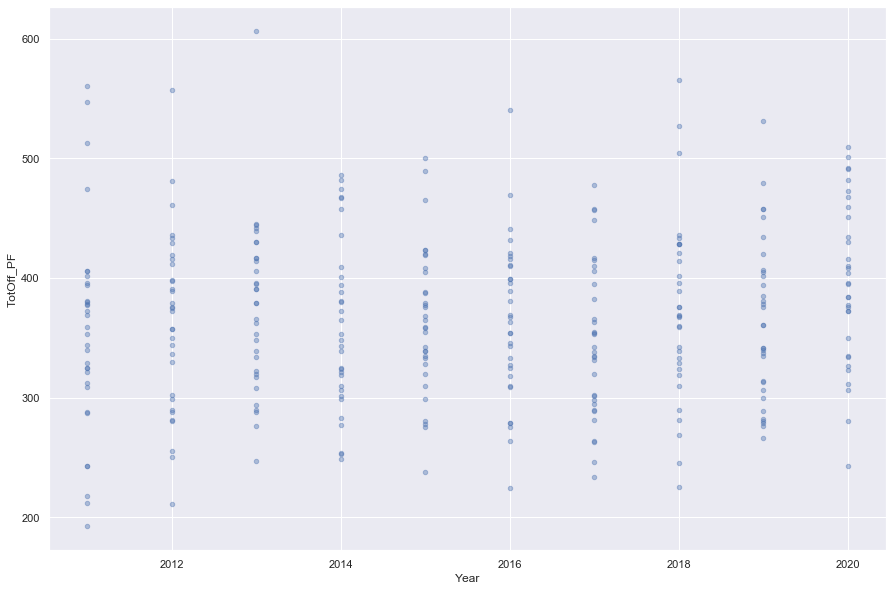

In [292]:
#scatter plot of total offense points scored vs year
MasterOFFcopy = MasterOFF
MasterOFFcopy.plot.scatter("Year", "TotOff_PF", figsize=(15, 10), alpha=0.4)

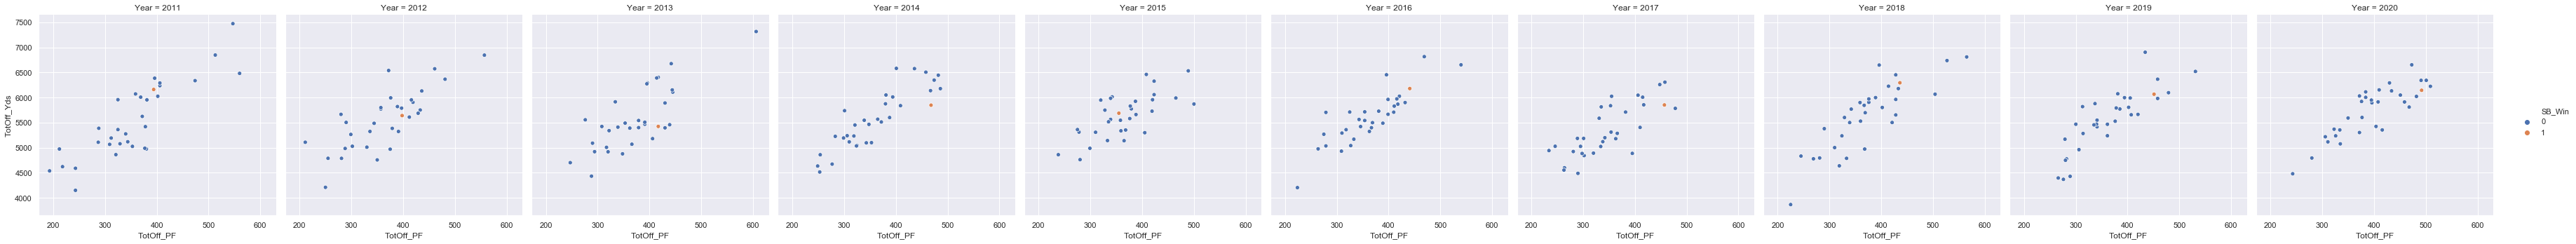

In [293]:
#relationship plot

sns.relplot(
    data=MasterOFFcopy,
    x="TotOff_PF", y="TotOff_Yds", col="Year", hue="SB_Win")

In [294]:
#Combine Offense and Defense Dataframes
DF_OFF_DEF = pd.merge(MasterOFF,MasterDEF, left_on =['TotOff_Tm','Year'], right_on = ['TotDef_Tm','Year'], how = 'left' )


In [295]:
DF_OFF_DEF.head(5)

,TotOff_Rk,TotOff_Tm,TotOff_G,TotOff_PF,TotOff_Yds,TotOff_Ply,TotOff_Y/P,TotOff_TO,TotOff_FL,TotOff_1stD,...,D_Rushing_TD,D_Rushing_Y/A,D_Rushing_1stD,D_Penalties_Pen,D_Penalties_Yds,D_Penalties_1stPy,D_Score%_Sc%,D_TurnOver%_TO%,D_EXP_EXP,Sk
0,1.0,Green Bay Packers,16.0,509.0,6224.0,990.0,6.3,11.0,6.0,358.0,...,16.0,4.5,119.0,79.0,734.0,29.0,39.9,11.4,-109.67,41.0
1,2.0,Buffalo Bills,16.0,501.0,6343.0,1034.0,6.1,22.0,11.0,397.0,...,21.0,4.6,125.0,86.0,728.0,27.0,39.4,15.3,-123.10,38.0
2,3.0,Tampa Bay Buccaneers,16.0,492.0,6145.0,1017.0,6.0,17.0,5.0,364.0,...,10.0,3.6,78.0,95.0,1015.0,26.0,33.7,14.0,-22.04,48.0
3,4.0,Tennessee Titans,16.0,491.0,6343.0,1031.0,6.2,12.0,5.0,381.0,...,18.0,4.5,113.0,103.0,840.0,31.0,45.2,13.3,-185.20,19.0
4,5.0,New Orleans Saints,16.0,482.0,6023.0,1045.0,5.8,17.0,9.0,367.0,...,11.0,3.9,85.0,64.0,517.0,50.0,34.7,13.1,-40.02,45.0


In [296]:
#merge offense, defense, and standings data
DF= pd.merge(DF_OFF_DEF,Standings, left_on =['TotOff_Tm','Year'], right_on = ['Tm','Year'])
DF.drop(['TotOff_Tm','TotDef_Tm','TotOff_G','TotDef_G'],axis = 1,inplace = True)

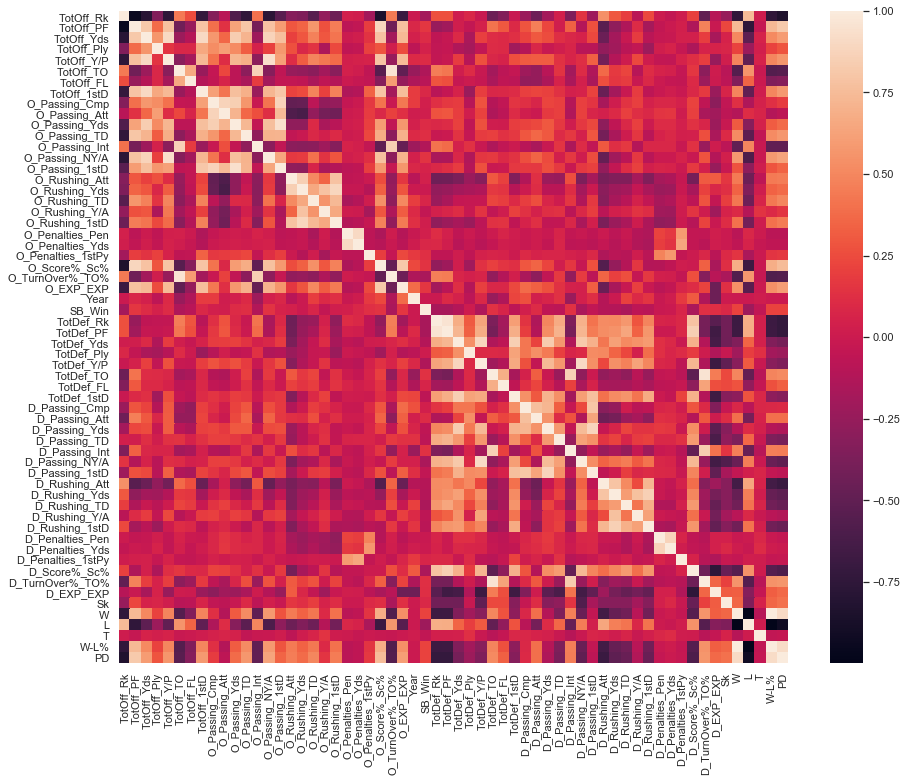

In [297]:
Var_Corr = DF.corr()
# plot the heatmap and annotation on it
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, ax = ax)

In [298]:
# Create new DFs without the 2020 season 
mask = (DF['Year'] != 2020)
DF_pre20 = DF[mask]
y_logit_train = DF_pre20['SB_Win']

In [299]:
X_logit_train = DF_pre20.drop(columns=['SB_Win', 'O_Score%_Sc%','O_TurnOver%_TO%','O_Rushing_Y/A','TotOff_Y/P','O_Passing_NY/A',
                                      'D_Passing_NY/A', 'TotDef_Y/P','D_Passing_NY/A','D_Rushing_Y/A','D_Score%_Sc%', 
                                      'D_TurnOver%_TO%'])
y_logit_train = DF_pre20['SB_Win']
X_logit_train2 = X_logit_train
offense_vars = []
defense_vars = ['Sk']
for col in X_logit_train2.columns:
    if 'O_' in col or 'Off' in col:
        offense_vars.append(col)
    if 'D_' in col or 'Def' in col:
        defense_vars.append(col)
off_cols_string = ' + '.join(offense_vars)
f = 'SB_Win ~ ' + off_cols_string

current_off_cols = []
for col in offense_vars:
    current_off_cols.append(col)
    rhs = ' + '.join(current_off_cols)
    f1 = 'SB_Win ~ ' + rhs
    try:
        off_logit_model = sm.logit(formula = f1, data = DF_pre20).fit(maxiter=10000,disp=0)
    except np.linalg.LinAlgError:
        current_off_cols = current_off_cols[0:-1]
        print(col+' results in a singular matrix and was dropped')
        continue
        
current_cols = current_off_cols
for col in defense_vars:
    current_cols.append(col)
    rhs = ' + '.join(current_cols)
    f1 = 'SB_Win ~ ' + rhs
    try:
        logit_model = sm.logit(formula = f1, data = DF_pre20).fit(maxiter=10000,disp=0)
    except np.linalg.LinAlgError:
        current_cols = current_cols[0:-1]
        print(col+' results in a singular matrix and was dropped')
        continue
        
        
no_nan_col = []
for i, p_value in enumerate(logit_model.pvalues[1:]):
    if np.isnan(p_value):
        continue
    else:
        no_nan_col.append(current_off_cols[i])

f2 = 'SB_Win ~ '+ ' + '.join(no_nan_col)
logit_model2 = sm.logit(formula = f2, data = DF_pre20).fit(maxiter=10000,disp=0)
logit_model2.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


O_Rushing_Yds results in a singular matrix and was dropped


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

D_Passing_TD results in a singular matrix and was dropped


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


D_Passing_1stD results in a singular matrix and was dropped


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


D_Rushing_Yds results in a singular matrix and was dropped
D_Rushing_TD results in a singular matrix and was dropped
D_Rushing_1stD results in a singular matrix and was dropped
D_Penalties_Pen results in a singular matrix and was dropped
D_Penalties_Yds results in a singular matrix and was dropped
D_Penalties_1stPy results in a singular matrix and was dropped
D_EXP_EXP results in a singular matrix and was dropped


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 SB_Win   No. Observations:                  288
Model:                          Logit   Df Residuals:                      266
Method:                           MLE   Df Model:                           21
Date:                Sun, 25 Apr 2021   Pseudo R-squ.:                  0.4972
Time:                        16:56:22   Log-Likelihood:                -20.136
converged:                       True   LL-Null:                       -40.050
Covariance Type:            nonrobust   LLR p-value:                  0.007806
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          18.1261     26.794      0.677      0.499     -34.388      70.640
TotOff_Rk          -0.5905      0.293     -2.018      0.044      -1.164      -0.017
TotOff_PF          -0.0406      0.036     -1.135      0.257      -0.111       0.030
TotOff_Yds         -0.0062      0.004     -1.686      0.092      -0.013       0.001
TotOff_Ply         -0.0612      0.074     -0.822      0.411      -0.207       0.085
TotOff_TO          -0.0096   6.26e+05  -1.53e-08      1.000   -1.23e+06    1.23e+06
TotOff_FL           0.0392   6.26e+05   6.26e-08      1.000   -1.23e+06    1.23e+06
O_Passing_Cmp      -0.1194      0.057     -2.100      0.036      -0.231      -0.008
O_Passing_Att       0.1108      0.085      1.309      0.191      -0.055       0.277
O_Passing_Yds       0.0095      0.005      2.043      0.041       0.000       0.019
O_Passing_TD       -0.1034      0.222     -0.466      0.641      -0.538       0.331
O_Passing_Int      -0.0497   6.26e+05  -7.95e-08      1.000   -1.23e+06    1.23e+06
O_Rushing_Att       0.0723      0.072      1.004      0.315      -0.069       0.214
O_Rushing_TD        0.0087      0.248      0.035      0.972      -0.477       0.494
O_Penalties_Pen    -0.0902      0.092     -0.983      0.326      -0.270       0.090
O_Penalties_Yds     0.0184      0.010      1.778      0.075      -0.002       0.039
O_EXP_EXP           0.0076      0.010      0.757      0.449      -0.012       0.027
TotDef_Rk          -0.4137      0.311     -1.329      0.184      -1.024       0.197
TotDef_PF           0.0226      0.044      0.516      0.606      -0.063       0.108
TotDef_Yds         -0.0042      0.004     -1.056      0.291      -0.012       0.004
TotDef_1stD         0.0631      0.056      1.127      0.260      -0.047       0.173
D_Passing_Cmp      -0.0336      0.037     -0.920      0.357      -0.105       0.038
D_Passing_Yds       0.0047      0.004      1.127      0.260      -0.003       0.013
===================================================================================

Possibly complete quasi-separation: A fraction 0.43 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [300]:
# This section shows the manual variable elimination based on p-value and R^2 of each model
# Only one variable is eliminated at a time, but the section was ran repeatedly until a model with variables with p-value
# within a significance level of 0.2

vars_to_drop = ['O_Passing_Int','O_Rushing_TD','TotOff_FL','TotOff_TO','O_Passing_TD','TotDef_PF','TotOff_Ply','O_Rushing_Att',
               'TotDef_Yds','D_Passing_Yds','D_Passing_Cmp','O_EXP_EXP','O_Penalties_Pen','TotOff_Yds']

update_cols = []
for i, col in enumerate(no_nan_col):
    if col in vars_to_drop:
        continue
    else:
        update_cols.append(col)    
update_cols

f3 = 'SB_Win ~ '+ ' + '.join(update_cols)
logit_model3 = sm.logit(formula = f3, data = DF_pre20).fit(maxiter=10000,disp=0)
logit_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 SB_Win   No. Observations:                  288
Model:                          Logit   Df Residuals:                      279
Method:                           MLE   Df Model:                            8
Date:                Sun, 25 Apr 2021   Pseudo R-squ.:                  0.4229
Time:                        16:56:22   Log-Likelihood:                -23.112
converged:                       True   LL-Null:                       -40.050
Covariance Type:            nonrobust   LLR p-value:                 4.279e-05
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -15.1832     10.071     -1.508      0.132     -34.922       4.556
TotOff_Rk          -0.3990      0.185     -2.151      0.031      -0.762      -0.035
TotOff_PF          -0.0281      0.020     -1.418      0.156      -0.067       0.011
O_Passing_Cmp      -0.0859      0.041     -2.102      0.036      -0.166      -0.006
O_Passing_Att       0.0499      0.023      2.126      0.034       0.004       0.096
O_Passing_Yds       0.0029      0.002      1.515      0.130      -0.001       0.007
O_Penalties_Yds     0.0091      0.003      2.708      0.007       0.003       0.016
TotDef_Rk          -0.3586      0.123     -2.918      0.004      -0.599      -0.118
TotDef_1stD         0.0416      0.023      1.799      0.072      -0.004       0.087
===================================================================================

Possibly complete quasi-separation: A fraction 0.33 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [301]:
# Predictions for 2020
mask = (DF['Year'] >= 2020)
DF_post20 = DF[mask]
teams = DF_post20['Tm']
preds = logit_model3.predict(exog=DF_post20)
for i, pred in enumerate(preds):
    print('Team: '+teams[i]+'; Probability of SB Win: {:.3f}%'.format(pred*100))

Team: Green Bay Packers; Probability of SB Win: 0.030%
Team: Buffalo Bills; Probability of SB Win: 1.103%
Team: Tampa Bay Buccaneers; Probability of SB Win: 2.527%
Team: Tennessee Titans; Probability of SB Win: 0.035%
Team: New Orleans Saints; Probability of SB Win: 0.888%
Team: Kansas City Chiefs; Probability of SB Win: 10.875%
Team: Baltimore Ravens; Probability of SB Win: 8.318%
Team: Seattle Seahawks; Probability of SB Win: 0.018%
Team: Indianapolis Colts; Probability of SB Win: 0.389%
Team: Las Vegas Raiders; Probability of SB Win: 0.003%
Team: Minnesota Vikings; Probability of SB Win: 0.000%
Team: Pittsburgh Steelers; Probability of SB Win: 0.091%
Team: Arizona Cardinals; Probability of SB Win: 0.202%
Team: Cleveland Browns; Probability of SB Win: 0.015%
Team: Miami Dolphins; Probability of SB Win: 0.041%
Team: Atlanta Falcons; Probability of SB Win: 0.023%
Team: Dallas Cowboys; Probability of SB Win: 0.001%
Team: Houston Texans; Probability of SB Win: 0.000%
Team: Los Angeles Ch

In [316]:
# This section shows the manual variable elimination based on p-value and R^2 of each model without the total offense
# and defense ranking derived from the site where the data was obtained.

# Only one variable is eliminated at a time, but the section was ran repeatedly until a model with variables with p-value
# within a significance level of 0.2
vars_to_drop = ['TotOff_Rk','TotDef_Rk','O_Passing_Int','D_Passing_Cmp','TotDef_Yds','O_Rushing_TD','TotOff_FL',
               'TotDef_1stD','D_Passing_Yds','TotOff_Ply','TotOff_TO','O_Rushing_Att','O_Penalties_Pen','O_Passing_TD',
               'TotOff_PF','TotOff_Yds']

update_cols = []
for i, col in enumerate(no_nan_col):
    if col in vars_to_drop:
        continue
    else:
        update_cols.append(col)    
update_cols

f3 = 'SB_Win ~ '+ ' + '.join(update_cols)
logit_model3 = sm.logit(formula = f3, data = DF_pre20).fit(maxiter=10000,disp=0)
logit_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 SB_Win   No. Observations:                  288
Model:                          Logit   Df Residuals:                      281
Method:                           MLE   Df Model:                            6
Date:                Sun, 25 Apr 2021   Pseudo R-squ.:                  0.3416
Time:                        17:02:16   Log-Likelihood:                -26.368
converged:                       True   LL-Null:                       -40.050
Covariance Type:            nonrobust   LLR p-value:                 0.0001238
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -7.6423      4.826     -1.584      0.113     -17.101       1.816
O_Passing_Cmp      -0.0609      0.032     -1.901      0.057      -0.124       0.002
O_Passing_Att       0.0324      0.019      1.697      0.090      -0.005       0.070
O_Passing_Yds       0.0026      0.002      1.548      0.122      -0.001       0.006
O_Penalties_Yds     0.0077      0.003      2.384      0.017       0.001       0.014
O_EXP_EXP           0.0090      0.005      1.776      0.076      -0.001       0.019
TotDef_PF          -0.0314      0.010     -3.273      0.001      -0.050      -0.013
===================================================================================
"""

In [317]:
# Predictions for 2020
mask = (DF['Year'] >= 2020)
DF_post20 = DF[mask]
teams = DF_post20['Tm']
preds = logit_model3.predict(exog=DF_post20)
for i, pred in enumerate(preds):
    print('Team: '+teams[i]+'; Probability of SB Win: {:.3f}%'.format(pred*100))

Team: Green Bay Packers; Probability of SB Win: 0.194%
Team: Buffalo Bills; Probability of SB Win: 2.364%
Team: Tampa Bay Buccaneers; Probability of SB Win: 2.466%
Team: Tennessee Titans; Probability of SB Win: 0.075%
Team: New Orleans Saints; Probability of SB Win: 0.884%
Team: Kansas City Chiefs; Probability of SB Win: 12.939%
Team: Baltimore Ravens; Probability of SB Win: 2.209%
Team: Seattle Seahawks; Probability of SB Win: 0.029%
Team: Indianapolis Colts; Probability of SB Win: 0.892%
Team: Las Vegas Raiders; Probability of SB Win: 0.024%
Team: Minnesota Vikings; Probability of SB Win: 0.004%
Team: Pittsburgh Steelers; Probability of SB Win: 0.310%
Team: Arizona Cardinals; Probability of SB Win: 0.188%
Team: Cleveland Browns; Probability of SB Win: 0.167%
Team: Miami Dolphins; Probability of SB Win: 0.057%
Team: Atlanta Falcons; Probability of SB Win: 0.099%
Team: Dallas Cowboys; Probability of SB Win: 0.012%
Team: Houston Texans; Probability of SB Win: 0.005%
Team: Los Angeles Ch